In [1]:
import re
import json

In [3]:
with open('Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 21220

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
0       2897211        21220               30   
52      1197973        21220               30   
53      1029304        21220               30   
253      658000        21220              122   
964     2825598        21220              369   

                                                 title  year  \
0    A wide range and high sensitivity four-channel...  2016   
52   Multi-sparse signal recovery for compressive s...  2012   
53   Low-Power Analog Integrated Circuits for Wirel...  2012   
253  Programming support for reconfigurable custom ...  2015   
964  A Low Complexity and High Throughput MIMO Dete...  2016   

                                              abstract  
0    We present a four-channel, high-sensitivity an...  
52   Signal recovery is one of the key techniques o...  
53   This paper presents low-power analog ICs for w...  
253  High performance requirements increased the po...  
964  This paper presents a linear Minimum Mean Squa...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

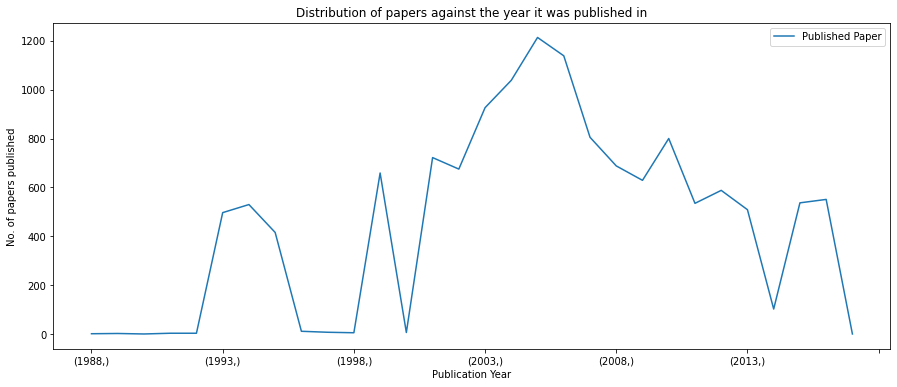

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2004 with year 2011 accounting for the highest number of papers.

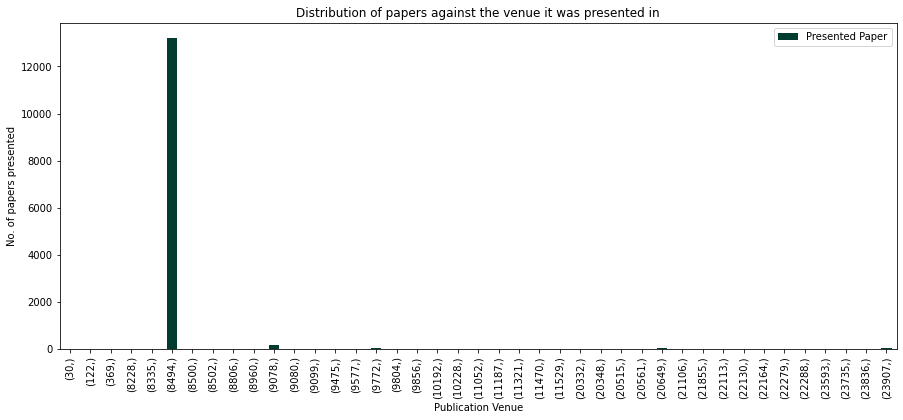

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [44]:
conference_data_dict[8494]

'international symposium on circuits and systems'

Venue of conferences are more spread out across this community, However, most of the papers still were presented in one conference (with conferenceId 8494) **International Symposium on Circuits and Systems**. We should be expecting papers about circuits and systems in papers of this community.

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

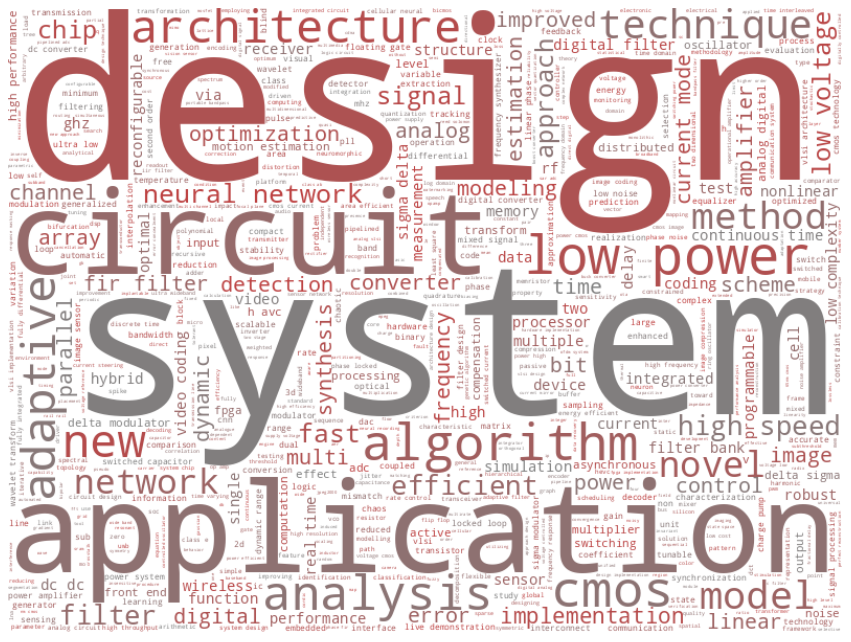

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, we can see that a lot of papers of the community focus on images and videos models and algorithms. Since most papers of the community were presented at a conference about image processing, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

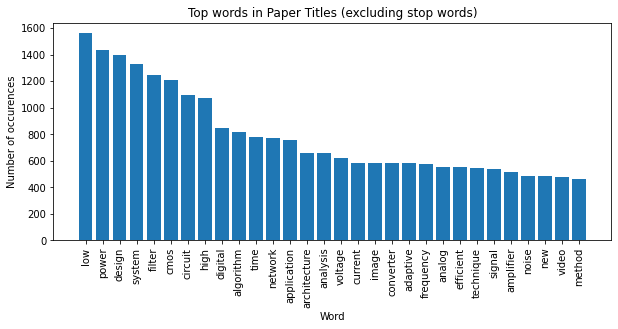

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are about power, designs and systems. Considering most papers are about circuits and systems, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.029*"design" + 0.023*"filter" + 0.020*"network" + 0.017*"algorithm" + 0.016*"system" + 0.015*"neural"'),
 (1,
  '0.036*"circuit" + 0.028*"network" + 0.022*"analysis" + 0.020*"signal" + 0.019*"power" + 0.014*"system"'),
 (2,
  '0.031*"high" + 0.024*"power" + 0.019*"delta" + 0.018*"sigma" + 0.017*"performance" + 0.014*"dc"'),
 (3,
  '0.029*"filter" + 0.023*"system" + 0.013*"algorithm" + 0.013*"bank" + 0.012*"signal" + 0.011*"digital"'),
 (4,
  '0.028*"cmos" + 0.023*"time" + 0.014*"filter" + 0.014*"continuous" + 0.013*"design" + 0.010*"multi"'),
 (5,
  '0.017*"state" + 0.012*"single" + 0.011*"digital" + 0.010*"system" + 0.010*"calibration" + 0.010*"pulse"'),
 (6,
  '0.031*"current" + 0.029*"high" + 0.025*"low" + 0.022*"filter" + 0.019*"voltage" + 0.017*"mode"'),
 (7,
  '0.029*"image" + 0.023*"time" + 0.019*"motion" + 0.015*"estimation" + 0.012*"application" + 0.012*"real"'),
 (8,
  '0.047*"low" + 0.029*"power" + 0.025*"cmos" + 0.023*"application" + 0.018*"amplifier" + 0.013*"hig

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

design    filter   network  algorithm    system    neural  efficient  \
0  0.029144  0.022667  0.020143   0.017284  0.016248  0.015423   0.014691   
1  0.009291  0.000000  0.028368   0.000000  0.013540  0.010087   0.000000   
2  0.011301  0.011609  0.000000   0.000000  0.013802  0.000000   0.000000   
3  0.010413  0.029089  0.000000   0.013258  0.022702  0.007236   0.000000   
4  0.012624  0.013880  0.000000   0.000000  0.000000  0.000000   0.000000   
5  0.000000  0.008296  0.000000   0.000000  0.010450  0.000000   0.000000   
6  0.010489  0.021615  0.000000   0.000000  0.000000  0.000000   0.000000   
7  0.009462  0.000000  0.000000   0.011664  0.008027  0.000000   0.000000   
8  0.012211  0.000000  0.000000   0.000000  0.009753  0.000000   0.000000   
9  0.013354  0.010265  0.000000   0.014826  0.007831  0.000000   0.009823   

     linear       new  approach  ...         h       264      rate       avc  \
0  0.013169  0.013161  0.012843  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.008202  ...  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.007393  ...  0.000000  0.000000  0.000000  0.000000   
4  0.007573  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.007139  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  ...  0.020448  0.016298  0.014629  0.011687   

    decoder  scalable  hardware  complexity  detection       dct  
0  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
1  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
2  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
3  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
4  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
5  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
6  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
7  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
8  0.000000  0.000000  0.000000    0.000000    0.00000  0.000000  
9  0.009138  0.008412  0.007958    0.007639    0.00755  0.006009  

[10 rows x 137 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


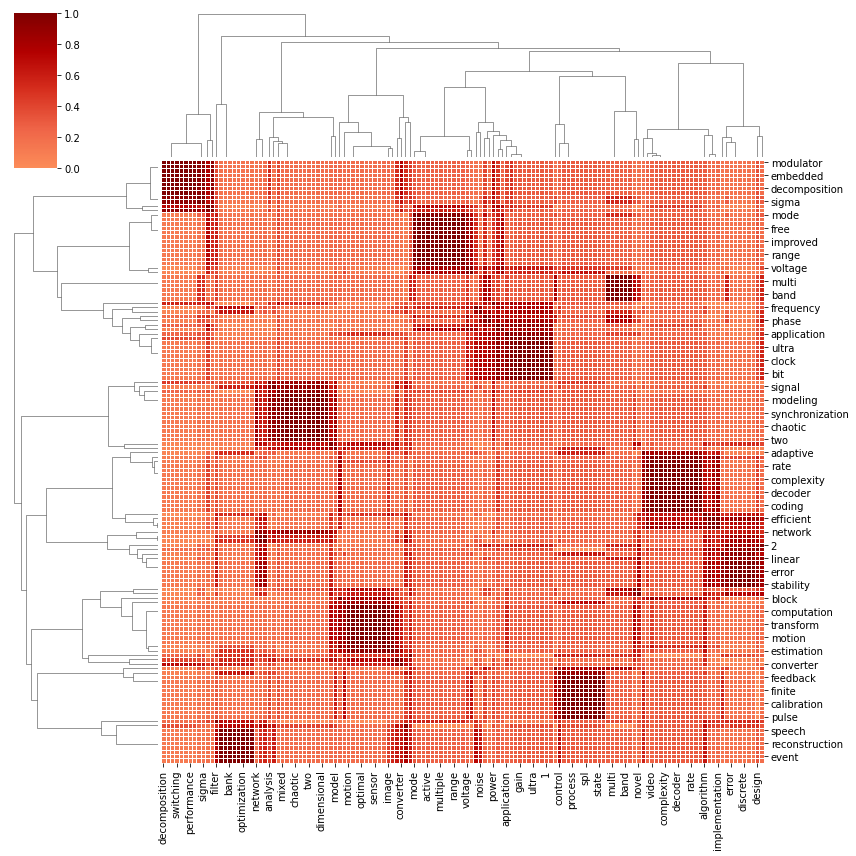

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  29.243914
5       0.648955  71.707100       2        1  13.498987
6      71.019684   9.971006       3        1  10.292599
9       3.785981  33.185135       4        1   8.356588
4     -42.666500  -9.222070       5        1   8.105445
3      -3.621689 -43.526516       6        1   6.906628
2      -3.632402  -4.171708       7        1   6.752684
7     -36.584400  35.804413       8        1   6.035990
8      44.391380  50.615383       9        1   5.407579
1      40.235809 -31.591665      10        1   5.399587, topic_info=        Term        Freq       Total Category  logprob  loglift
24       low  118.000000  118.000000  Default  30.0000  30.0000
105    video   52.000000   52.000000  Default  29.0000  29.0000
6       high  103.000000  103.000000  Default  28.0000  28.0000
44      time   94.000000   94.000000  Default  27.0000  27.0000
201     cmos  105.000000  105.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
35    design    6.826431  210.641463  Topic10  -4.6787  -0.5105
608   domain    4.416641   20.223728  Topic10  -5.1141   1.3974
20    analog    5.025289   57.392734  Topic10  -4.9850   0.4834
63   digital    4.849506  109.574486  Topic10  -5.0206  -0.1989
56    sensor    4.449122   31.704197  Topic10  -5.1068   0.9551

[750 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1278      3  0.372305        's
1278      6  0.124102        's
1278     10  0.496406        's
660       3  0.224633         0
660       5  0.748778         0
...     ...       ...       ...
54        9  0.609103  wideband
3289      8  0.998711    window
2513      7  0.703509      word
678       8  0.688587     yield
2841     10  1.211882         z

[1419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 10, 5, 4, 3, 8, 9, 2])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  plane, combined, focal, overview, biological, value, recent, chemical, multiphase, detecting, clocked, custom, accelerator, geometry, polarization

Paper Titles:
Epistemic utility estimation with valuational convexity
Chemical and biological sensors for environmental monitoring
Construction of an (r11, r12, r22)-Tournament from a Score Sequence Pair
Confronting violations of the TSCG(T) in low-power design

****************************************************************************************************
TOPIC 1:
Top Words:  power, system, circuit, low, transmission, interface, noise, neural, network, wireless, design, chip, channel, analysis, cmos

Paper Titles:
A 0.035mm2 150mA fast-response low-dropout regulator based on matching-enhanced error amplifier and multi-threshold-controlled unity-gain buffer in 0.13μm CMOS
Full quiescent current enhancement technique for improving transient response on the output-capacitorless Low-Dropout regulator
The design of an 

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

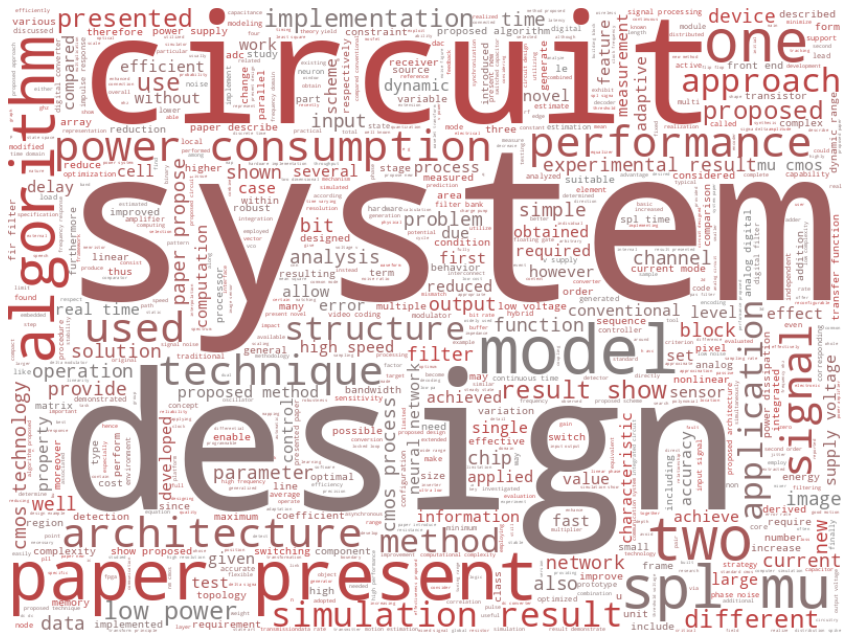

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.009*"design" + 0.008*"proposed" + 0.006*"system" + 0.006*"method" + 0.005*"circuit" + 0.005*"noise" + 0.004*"paper"'),
 (1,
  '0.004*"g sub" + 0.004*"power" + 0.003*"3 spl" + 0.003*"charge pump" + 0.003*"design" + 0.003*"op amp" + 0.003*"frame skipping"'),
 (2,
  '0.010*"coding" + 0.010*"proposed" + 0.009*"algorithm" + 0.007*"frame" + 0.006*"h 264" + 0.006*"video" + 0.005*"scheme"'),
 (3,
  '0.008*"circuit" + 0.006*"sensor" + 0.006*"system" + 0.005*"proposed" + 0.004*"current" + 0.003*"control" + 0.003*"new"'),
 (4,
  '0.014*"proposed" + 0.013*"filter" + 0.010*"image" + 0.007*"architecture" + 0.005*"design" + 0.005*"algorithm" + 0.005*"time"'),
 (5,
  '0.010*"proposed" + 0.008*"architecture" + 0.006*"design" + 0.005*"method" + 0.005*"implementation" + 0.005*"performance" + 0.005*"time"'),
 (6,
  '0.018*"circuit" + 0.012*"proposed" + 0.009*"spl mu" + 0.008*"voltage" + 0.007*"cmos" + 0.007*"frequency" + 0.007*"presented"'),
 (7,
  '0.015*"system" + 0.013*"algorithm" + 0.011*"me

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

design  proposed    system    method   circuit     noise     paper  \
0  0.008784  0.007927  0.006499  0.005590  0.004887  0.004538  0.004387   
1  0.002913  0.002431  0.000000  0.001719  0.002537  0.000000  0.000000   
2  0.000000  0.009623  0.000000  0.003352  0.000000  0.000000  0.000000   
3  0.000000  0.005448  0.005664  0.000000  0.008166  0.000000  0.002458   
4  0.005468  0.014456  0.000000  0.003946  0.000000  0.004646  0.003714   
5  0.006394  0.010441  0.000000  0.005480  0.000000  0.000000  0.004027   
6  0.006177  0.011889  0.004117  0.000000  0.018424  0.000000  0.000000   
7  0.009603  0.005764  0.015020  0.011172  0.009404  0.000000  0.005537   
8  0.018110  0.007933  0.003461  0.000000  0.009331  0.000000  0.000000   
9  0.000000  0.002239  0.000000  0.000000  0.006588  0.002079  0.002219   

     signal    filter      time  ...  implemented   dc dc  slew rate  \
0  0.003933  0.003483  0.003398  ...     0.000000  0.0000   0.000000   
1  0.000000  0.000000  0.000000  ...     0.000000  0.0000   0.000000   
2  0.000000  0.000000  0.000000  ...     0.000000  0.0000   0.000000   
3  0.001879  0.000000  0.001959  ...     0.000000  0.0000   0.000000   
4  0.003668  0.012737  0.004812  ...     0.000000  0.0000   0.000000   
5  0.000000  0.000000  0.004841  ...     0.000000  0.0000   0.000000   
6  0.000000  0.000000  0.000000  ...     0.000000  0.0000   0.000000   
7  0.000000  0.000000  0.004386  ...     0.000000  0.0000   0.000000   
8  0.004177  0.016731  0.000000  ...     0.002776  0.0000   0.000000   
9  0.000000  0.000000  0.000000  ...     0.000000  0.0029   0.002434   

      given  winner take   class e  test pattern  parameter    effect  \
0  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
1  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
2  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
3  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
4  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
5  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
6  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
7  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
8  0.000000     0.000000  0.000000      0.000000   0.000000  0.000000   
9  0.002354     0.002254  0.002188      0.002131   0.002082  0.002072   

   paper consider  
0         0.00000  
1         0.00000  
2         0.00000  
3         0.00000  
4         0.00000  
5         0.00000  
6         0.00000  
7         0.00000  
8         0.00000  
9         0.00202  

[10 rows x 117 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



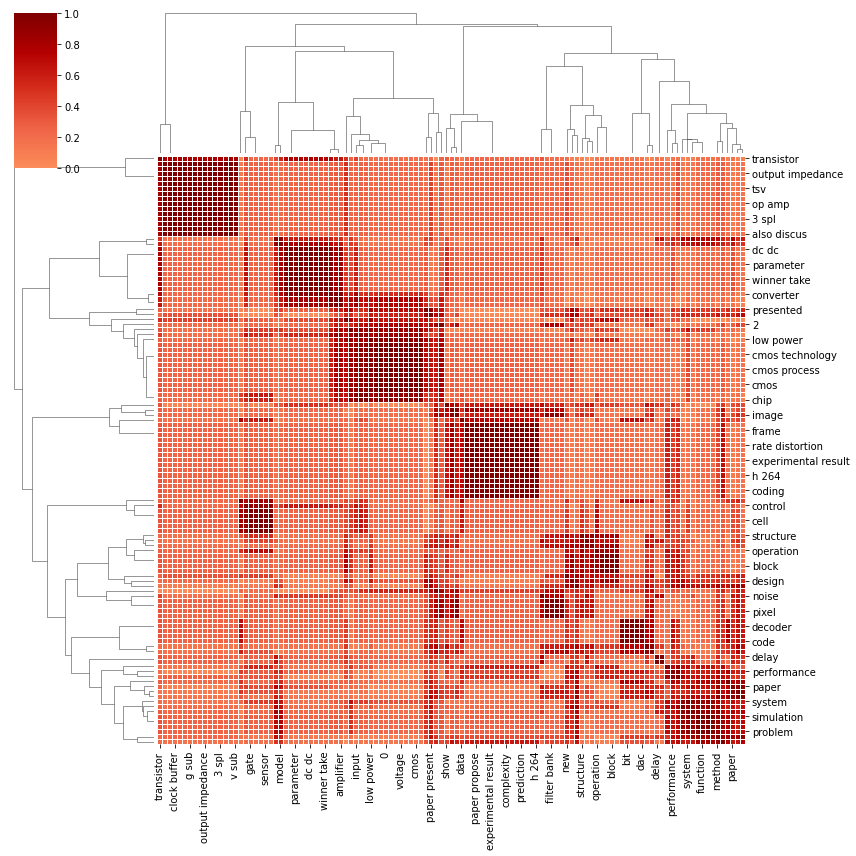

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  47.347290
5       0.648955  71.707100       2        1  11.261307
4      71.019684   9.971006       3        1   5.473507
8       3.785981  33.185135       4        1   5.268082
7     -42.666500  -9.222070       5        1   5.256461
2      -3.621689 -43.526516       6        1   5.078967
3      -3.632402  -4.171708       7        1   5.078794
0     -36.584400  35.804413       8        1   5.078649
9      44.391380  50.615383       9        1   5.078503
1      40.235809 -31.591665      10        1   5.078439, topic_info=            Term        Freq       Total Category  logprob  loglift
236       design   84.000000   84.000000  Default  30.0000  30.0000
136       filter   35.000000   35.000000  Default  29.0000  29.0000
163     proposed  132.000000  132.000000  Default  28.0000  28.0000
55        system   56.000000   56.000000  Default  27.0000  27.0000
412      circuit  153.000000  153.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
103    technique    1.216059   45.968211  Topic10  -6.3426  -0.6522
161    presented    1.203160   69.112845  Topic10  -6.3532  -1.0706
991         gate    1.027284   11.135619  Topic10  -6.5112   0.5969
541         used    1.011491   35.032383  Topic10  -6.5267  -0.5647
1265  efficiency    0.965733    9.175373  Topic10  -6.5730   0.7288

[824 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
25360      2  0.961898   's complement
474        1  0.884083               0
474        2  0.030486               0
474        3  0.030486               0
474        6  0.030486               0
...      ...       ...             ...
23501      7  1.803269  wavelet filter
9442       9  1.782272  white gaussian
14672      9  1.257342     winner take
1821       8  0.826227            wire
17411      9  1.633034     wta circuit

[1181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 9, 8, 3, 4, 1, 10, 2])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  power reclamation, reclamation network, power reclamation network, reclamation, zr, outphasing, fe zr, hydrogenation, 256 channel, bcc, lst, bcc identification, ca education, residential, magnetization strain hydrogenation

Paper Titles:
Development of the hydrogen gas sensor for the nondestructive test evaluation (NDE) application
Teaching electronic circuits online: Lessons from MITx's 6.002x on edX
Developments on the Boston 256-channel retinal implant
Frequency scaling of power reclamation networks in outphasing PA architectures

****************************************************************************************************
TOPIC 1:
Top Words:  ggfst, ggfst method, quantum cost, ternary reversible, ancilla, read yield, quantum divider, tgfsop, switched nonlinear system, branch voltage current, law may violated, branch voltage, may violated, law may, quantum cost ancilla

Paper Titles:
The relationship between music processing and electrocardiogram (ECG) in

In [42]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [43]:
representative_df.to_csv("repr_21220.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
31942      673218        21220             8494   
28817     1370120        21220             8494   
94786      861397        21220            11470   
28835     1390088        21220             8494   
32517      527754        21220             8494   
...           ...          ...              ...   
22362     2879935        21220             8494   
22042     2888551        21220             8494   
22187     2922384        21220             8494   
22262     2843047        21220             8494   
22202     2863256        21220             8494   

                                                   title  year  \
31942  Development of the hydrogen gas sensor for the...  1999   
28817  Teaching electronic circuits online: Lessons f...  2013   
94786  Developments on the Boston 256-channel retinal...  2013   
28835  Frequency scaling of power reclamation network...  2012   
32517  Modelling of multidimensional (MD) heat diffus...  2015   
...                                                  ...   ...   
22362  Fast intra prediction algorithm and design for...  2016   
22042  A bidirectional neural interface IC with high ...  2016   
22187  A high wide band PSRR and fast start-up curren...  2016   
22262  A high efficiency single-inductor dual-output ...  2016   
22202  Efficient architecture for soft-output massive...  2016   

                                                abstract  
31942  In this paper, a sensor material with Fe/Zr mu...  
28817  6.002x is the first electronic circuits course...  
94786  A hermetic neurostimulator is being developed ...  
28835  Outphasing power amplifiers (PAs) with power r...  
32517  Motivated by gas dynamics, we consider the hea...  
...                                                  ...  
22362  To meet the real time demand of HEVC intra enc...  
22042  This paper presents a fully integrated, bidire...  
22187  This paper presents a high wide band power sup...  
22262  A single-inductor dual-output (SIDO) buck conv...  
22202  In massive multiple-input multiple-output (MIM...  

[1032 rows x 6 columns]